**Table of contents**<a id='toc0_'></a>   
- 1. [Imports](#toc1_)     
- 2. [IS-LM model](#toc2_)    
- 3. [Comparing different estimation solvers](#toc3_)      
- 4. [Model modifications](#toc4_)  
 - 4.1. [IS-LM model with contractionary Monetary and fiscal Policy](#toc4_1_)
 - 4.2. [IS-LM model with fiscal Policy](#toc4_2_)   
- 5. [Interactive figure](#toc5_)    
- 6. [Model extension](#toc6_)

## 1. <a id='toc1_'></a>[Imports](#toc1_)

In [6]:
import seaborn as sns
sns.set(style='whitegrid')

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

%matplotlib inline
from matplotlib import cm
from matplotlib import rc
import matplotlib.ticker as ticker
import ipywidgets as widgets
from ISLMModel import ODESolver
from ISLMModel import RungeKutta4
from ISLMModel import ForwardEuler
from ISLMModel import *


## 2. <a id='toc2_'></a>[IS-LM model](#toc2_)

The IS-LM model is a macroeconomic framework which shows the interaction between good and money market, to show the equilibrium between total output and interest rates. The purpose of the model is to get a clear understanding on how the interaction of an economy seen from a policymakers perspective and observes the behavioral pattern between agents.

Our model is based on a closed economy where the goods market is represented through GDP at time (t) determined by the sum of investment, government spendings, consumption and exports.


\begin{align*}
Y(t) = C(t) + I(t) + G(t) \tag{1}                      
\end{align*}

Household consumption $C(t)$ is:

\begin{align*}
C(t) = a + bY_d(t) \tag{2}                      
\end{align*}

Disposable income of households is the  difference between $Y(t)$ and taxes $T(t)$.

\begin{align*}
Y_d(t) = Y(t) - T(t) \tag{3}
\end{align*}

Taxes $T(t)$ is described by total fixed taxes $T$ and the variable taxes given as a percentange $\lambda$ multiplied with GDP $Y(t)$.

\begin{align*}
T(t) = T + \lambda Y(t) \tag{4}
\end{align*}

The total investment at any time $t$ refers to the difference between the level ofinvestments $I_o$ and the  sensitivity of the investment in relation to the interest rate $h$ and the real interest rate $r$.

\begin{align*}
I(t) = I_o - h r(t) \tag{5}
\end{align*}

Government expenditure is fixed.

\begin{align*}
G(t) = \bar{G} \tag{6}
\end{align*}



The money market:


The money demand ($M_d(t)$), is the sum of: Demand for money (($M_o$), Product of sensitivity of the demand for money to output ($k$) and the GDP ($Y(t)$). We note that a reduction in demand should be proportional to the sensitivity of demand for money in regards to the interst rate mulitplied by the interst rate itself.



\begin{align*}
M_d(t) = M_o + k Y(t) - \mu r(t) \tag{7}
\end{align*}

The money supply is fixed.

\begin{align*}
M_s(t) = \bar{M} \tag{8}
\end{align*}

T market clearing condition is that the demand for money should be equal to the supply for money.

\begin{align*}
M_d(t) = M_s(t) \tag{9}
\end{align*}

We model achange in output $Y(t)$ in regards to time $t$ by taking the derivative of $Y$ with respect to $t$:

\begin{align*}
\frac{dy}{dt} = \alpha(C(t) + I(t) + G(t) - Y(t)) \tag{10}
\end{align*}

where $\alpha$ is the speed of adjustment to equilibrium in the goods market.

The differential is derived from the equations that shows the change of output (GDP) over time.

Inserting equation 2-6 we get:

\begin{align*}
\frac{dy}{dt} = \alpha(a + bY_d(t) + I_o - hr(t) + \bar{G} - Y(t)) 
\end{align*}

\begin{align*}
\frac{dy}{dt} = \alpha(a + b(Y(t) - T(t)) + I_o - hr(t) + \bar{G} - Y(t)) 
\end{align*}

\begin{align*}
\frac{dy}{dt} = \alpha(a + b(Y(t) - (T_o + \lambda Y(t))) + I_o - hr(t) + \bar{G} - Y(t)) 
\end{align*}

\begin{align*}
\frac{dy}{dt} = \alpha(a - bT_o + I_o + \bar{G}) - \alpha((1-b)(1-\lambda)Y(t)) - \alpha hr(t) \tag{11}
\end{align*}

We model the differntial equation that explains the change in real interst rate.

\begin{align*}
\frac{dr}{dt} = \beta(M_d(t) - M_s(t)) 
\end{align*}

where $\beta$ is the speed of adjustment to equilibrium in the money market.

We assume that $\beta > \alpha$.

Inserting equation 7-9, we get:

\begin{align*}
\frac{dr}{dt} = \beta(M_o + k Y(t) - \mu r(t) - \bar{M}) 
\end{align*}

\begin{align*}
\frac{dr}{dt} = \beta(M_o - \bar{M} + k Y(t) - \mu r(t)) \tag{12}
\end{align*}

Our final model is represented by Eq. (11) and Eq. (12) where they depend on Y(t) and r(t), both are endogenous variables. Where $I_o$, $T$ and $M_o$ are exogoneous 



### 3. <a id='toc3_'></a>[Comparing different estimation solvers](#toc3_)

The following section of code of defines and solves the model, using the Forward Euler solver and the ODE solver.

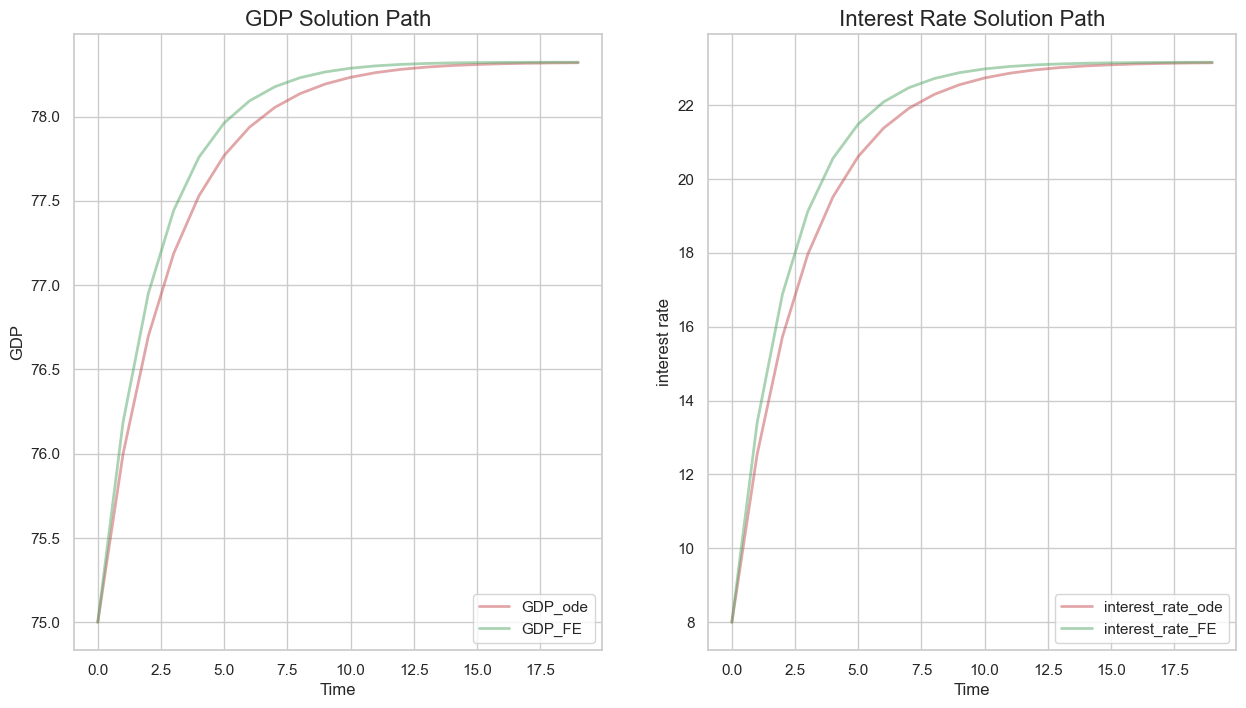

In [ ]:
#Parameters for the model

a = 15 # consumption
I_0 = 10 # investment
T_0 = 0 # fixed taxes
M_0 = 0 # Money demand
alpha_val = 0.05 # speed of adjustment in goods market
beta_val = 0.8  # speed of adjustment in money market
lambda_val = 0.25 # variable taxes
b = 0.75 # marginal propensity to consume 
h = 1.525 # sensitivity of investment in relation to interest rates
k = 0.25 # sensitivity of demand for money in relation to GDP
mu_val = 0.5 # sensitivity of demand for money in relation to interest rates
G = 25 # government spending
M = 8 # money supply fixed

time_points = np.arange(0, 20)

def IS_LM_model(u, t):    
    GDP, interest_rate = u[0], u[1]
    dYdt = ((alpha_val * (a - b * T_0 + I_0 + G)) - 
            (alpha_val * ((1-b) * (1-lambda_val) * GDP)) - 
            (alpha_val * h * interest_rate)) 
    drdt = beta_val * (M_0 - M + k * GDP - (mu_val * interest_rate))
    return [dYdt, drdt]


# Initial conditions vector
Y_0 = 75
r_0 = 8

# solve using Forward Euler
solver_FE = ForwardEuler(IS_LM_model)
solver_FE.set_initial_condition([Y_0, r_0])
u, t = solver_FE.solve(time_points)
GDP_FE = u[:, 0]
interest_rate_FE = u[:, 1]

# The IS-LM model differential equations
def system(init_values, t, a, I_0, T_0, M_0, G, M, alpha_val, beta_val, 
           lambda_val, b, h, k, mu_val):
    GDP, interest_rate = init_values
    dYdt = ((alpha_val * (a - b * T_0 + I_0 + G)) - 
            (alpha_val * ((1-b) * (1-lambda_val) * GDP)) - 
            (alpha_val * h * interest_rate)) 
    drdt = beta_val * (M_0 - M + k * GDP - (mu_val * interest_rate))
    return dYdt, drdt

init_conds = Y_0, r_0
args_tuple = (a, I_0, T_0, M_0, G, M, alpha_val, beta_val, lambda_val, b, h, k, mu_val)

# Integrate the IS-LM differential equations over the time grid, t.
ret = odeint(system, init_conds, time_points, args=args_tuple)

GDP_odeint, interest_rate_odeint = ret.T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].plot(t, GDP_odeint, 'r', alpha=0.5, lw=2, label='GDP_ode')
ax[0].plot(t, GDP_FE, 'g', alpha=0.5, lw=2, label='GDP_FE')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('GDP')
ax[0].set_title('GDP Solution Path', fontsize=16)
ax[0].legend(loc=4)

ax[1].plot(t, interest_rate_odeint, 'r', alpha=0.5, lw=2, label='interest_rate_ode')
ax[1].plot(t, interest_rate_FE, 'g', alpha=0.5, lw=2, label='interest_rate_FE')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('interest rate')
ax[1].set_title('Interest Rate Solution Path', fontsize=16)
ax[1].legend(loc=4)
plt.show()

From the figure above, we see that the prediction of GDP and the interest rates are lower using the ODE solver, than the Forward Eulrer. This difference grows, as time goes on, until the economy hits its steady state level.

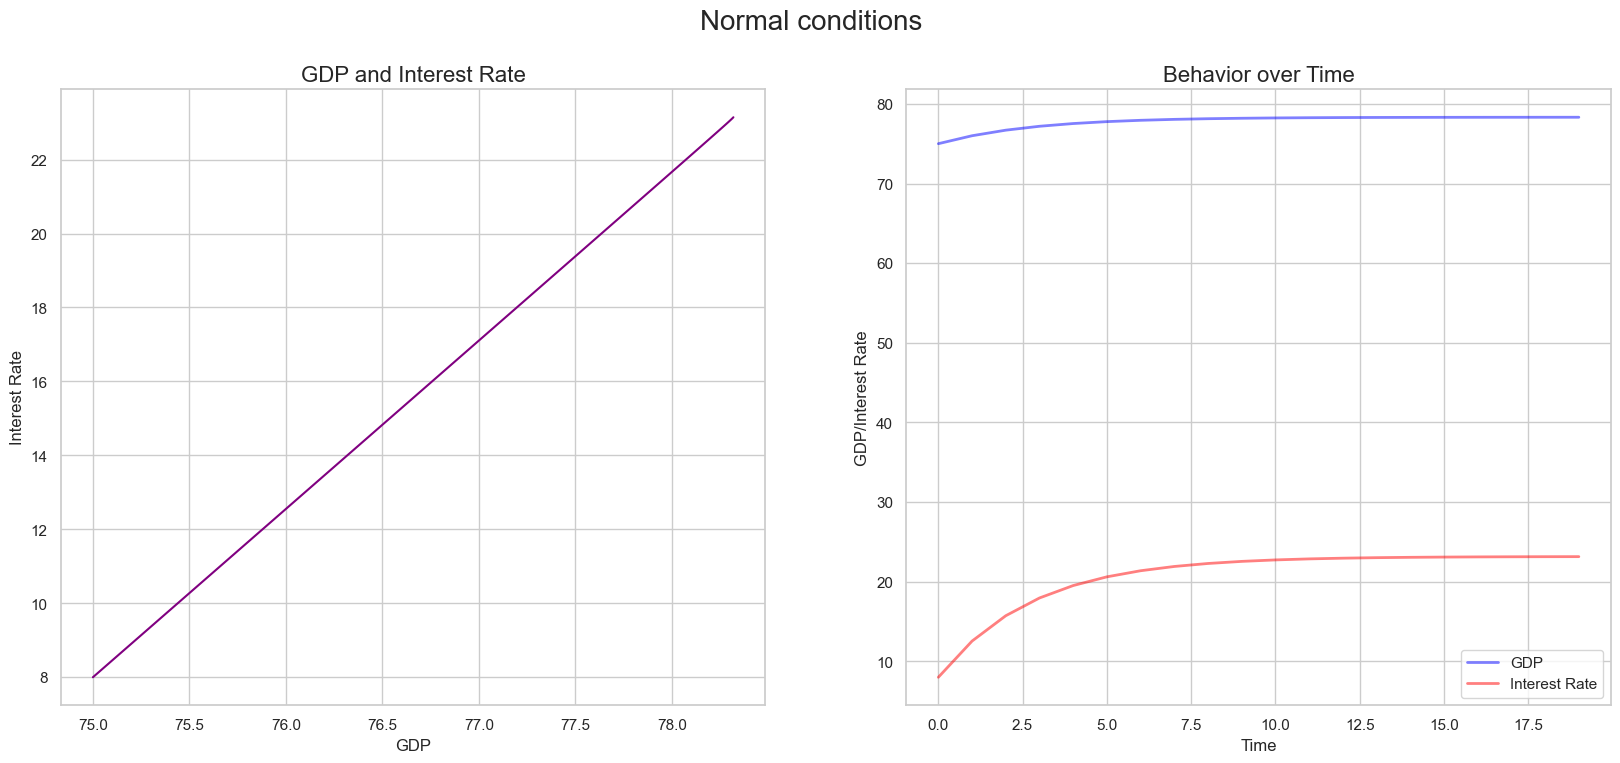

In [ ]:
def graph(GDP, interest_rate, t, case):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    plt.suptitle(case, fontsize=20)

    ax[0].plot(GDP, interest_rate, color='purple')
    ax[0].set_title('GDP and Interest Rate', fontsize=16)
    ax[0].set_xlabel('GDP')
    ax[0].set_ylabel('Interest Rate')

    ax[1].plot(t, GDP, color='blue', alpha=0.5, lw=2, label='GDP')
    ax[1].plot(t, interest_rate, color='red', alpha=0.5, lw=2, label='Interest Rate')
    ax[1].set_title('Behavior over Time', fontsize=16)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('GDP/Interest Rate')
    ax[1].legend()
    plt.show()

graph(GDP_odeint, interest_rate_odeint, t, 'Normal conditions')

In the figure above we have plotted the behavior of GDP and interest rates over time, for the case where the economy is controlled under normal conditions.

### 4. <a id='toc4_'></a>[Model modifications](#toc4_)


In the figures graphing the GDP and interest rate solution paths, the green line shows the model under normal conditions.

### 4.1 <a id='toc4_1_'></a>[IS-LM model with contractionary Monetary and Fiscal Policy ](#toc4_1_)

We are now going to to analyze a scenario where the central bank decreases the money supply, which is done to control inflation levels and volatility in output. In the simulation, the change is implemented by reducing the money supply from 8 to 4. Also, the government increases taxes to support the contractionary monetary policy agenda. 

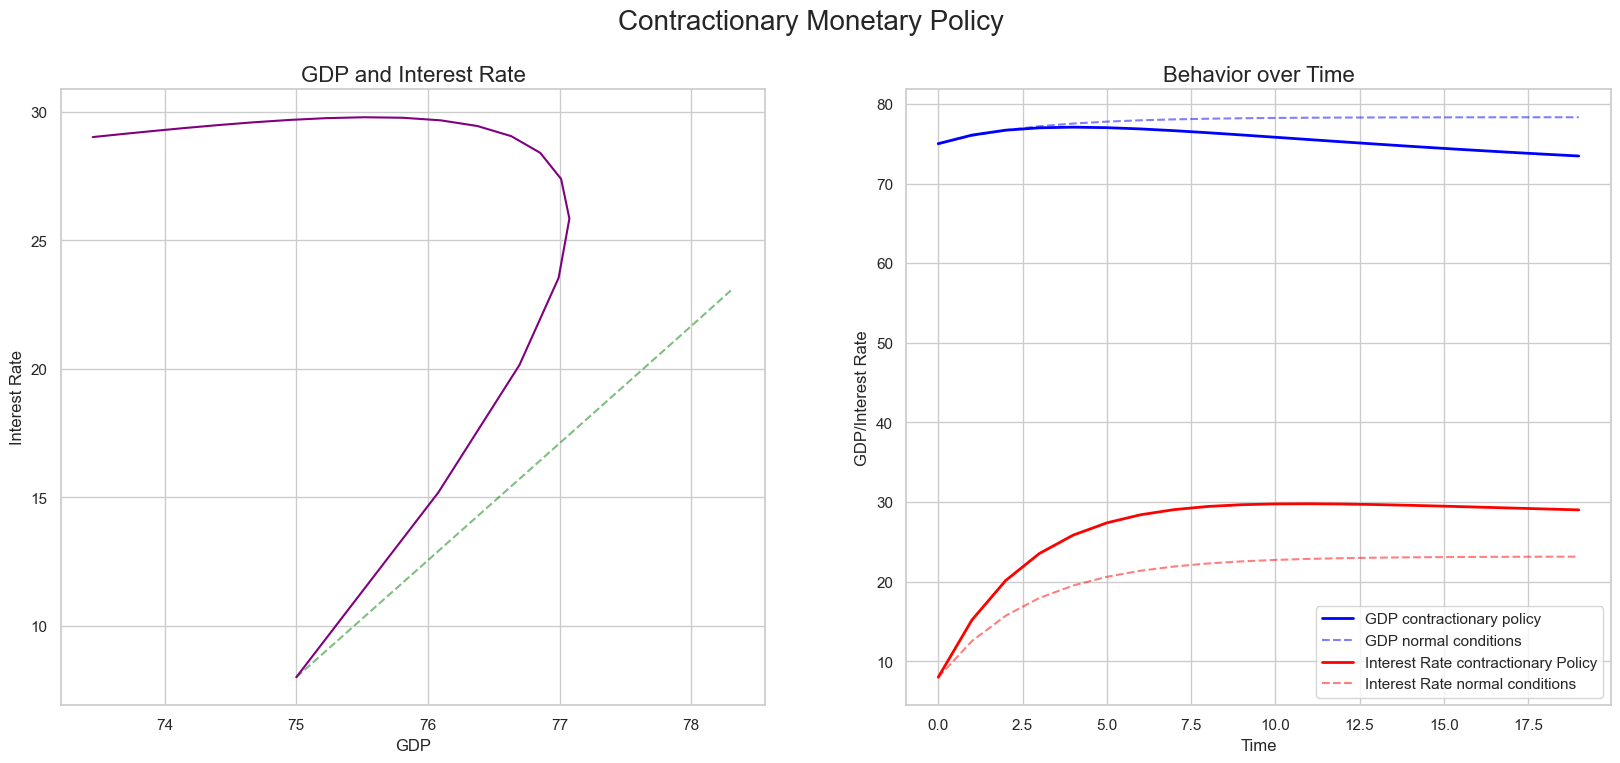

In [ ]:
# We only have to change the money supply and the variable taxes to see the effect on the model, since all the paramteres have already been defined, 
M = 4 # Changed money supply from 8 to 4
lambda_val = 0.45 # increase in variable taxes

def contractionarymodification(GDP, interest_rate, t, case):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    plt.suptitle(case, fontsize=20)
    
    ax[0].plot(GDP_odeint, interest_rate_odeint, color='Green', alpha=0.5, linestyle='--', label='Normal conditions')
    ax[0].plot(GDP, interest_rate, color='purple', label='Policy')
    ax[0].set_title('GDP and Interest Rate', fontsize=16)
    ax[0].set_xlabel('GDP')
    ax[0].set_ylabel('Interest Rate')

    ax[1].plot(t, GDP, color='blue', lw=2, label='GDP contractionary policy')
    ax[1].plot(t, GDP_odeint, color='blue', alpha=0.5, linestyle='--', label='GDP normal conditions')
    ax[1].plot(t, interest_rate, color='red', lw=2, label='Interest Rate contractionary Policy')
    ax[1].plot(t, interest_rate_odeint, color='red', alpha=0.5, linestyle='--', label='Interest Rate normal conditions')
    ax[1].set_title('Behavior over Time', fontsize=16)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('GDP/Interest Rate')
    ax[1].legend()
    plt.show()

init_conds = Y_0, r_0
args_tuple = (a, I_0, T_0, M_0, G, M, alpha_val, beta_val, lambda_val, b, h, k, mu_val)

# Integrate the IS-LM differential equations over the time grid
ret_contract = odeint(system, init_conds, time_points, args=args_tuple)

GDP_contract, interest_rate_contract = ret_contract.T

contractionarymodification(GDP_contract, interest_rate_contract, time_points, 'Contractionary Monetary Policy')

When the money supply is decreased central banks in order to execute contractionary monetary policy by increasing the interest rate, lending becomes more costly and the domestic investment decreases. Consequently, the economic growth rate decreases which can be seen by the decrease in GDP over time. 


### 4.2. <a id='toc4_2_'></a>[IS-LM model with Fiscal policy changes](#toc4_2_)

Now consider a case where the economy is hit by a recession, which results in a decline in private consumption. Consequently, the marginal propensity to consume for private households will decrease, leading to a decrease in b. The government then reacts by increasing spending to avoid a reduction in GDP, which can be seen as an increase in G. 


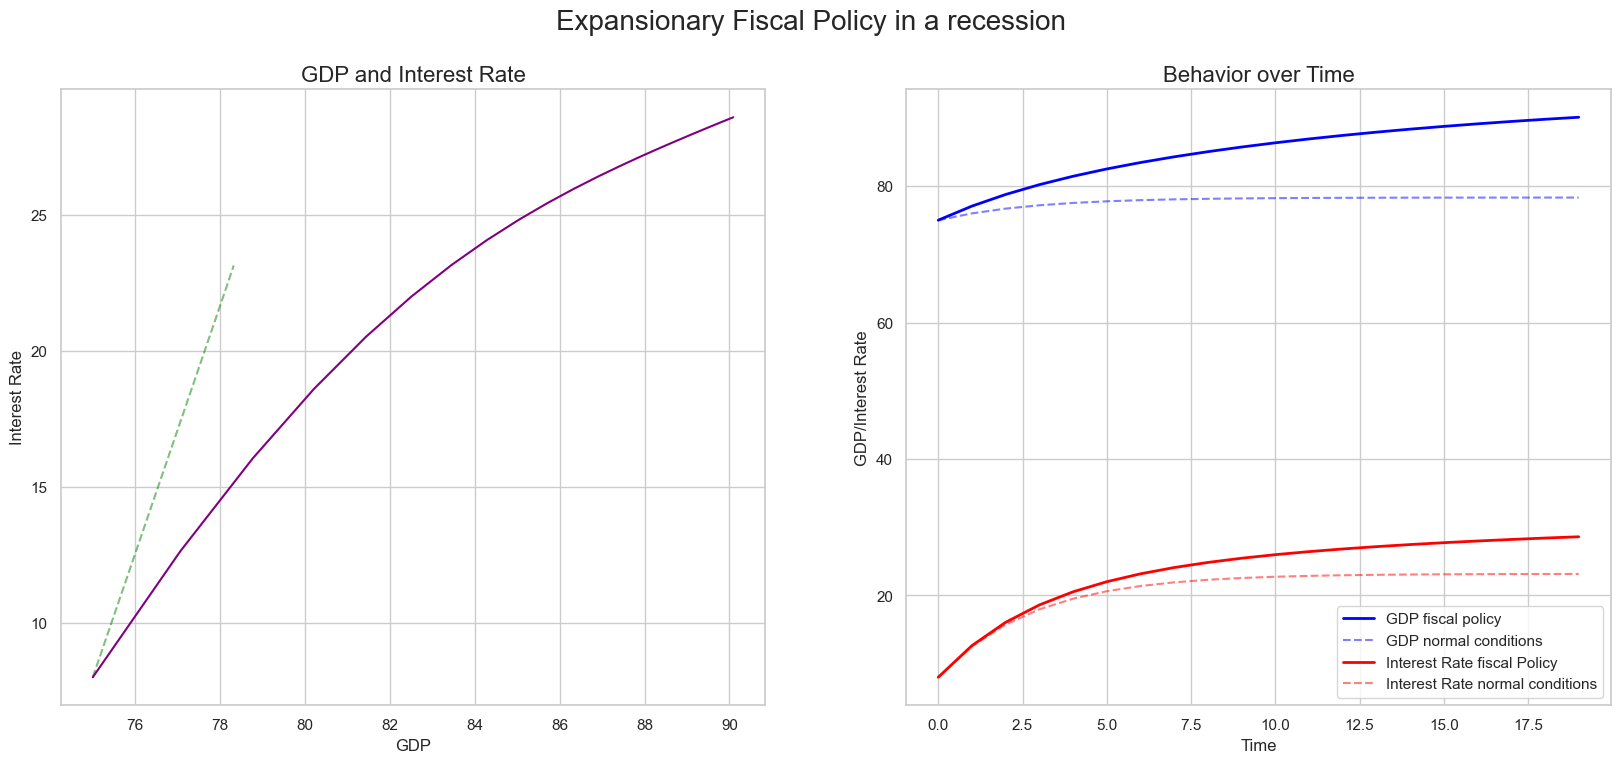

In [ ]:
# We only have to change the money supply back to the original value, since all the paramteres have already been defined.
# We change G and B to the new values to see the effect on the model.
G = 75 # Increase in public spending
M = 8 # Money supply changed to original value
lambda_val = 0.25 # original variable taxes
b = 0.25 # reduced from 0.75 to 0.25

def fiscalmodification(GDP, interest_rate, t, case):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    plt.suptitle(case, fontsize=20)
    
    ax[0].plot(GDP_odeint, interest_rate_odeint, color='Green', alpha=0.5, linestyle='--', label='Normal conditions')
    ax[0].plot(GDP, interest_rate, color='purple', label='Policy')
    ax[0].set_title('GDP and Interest Rate', fontsize=16)
    ax[0].set_xlabel('GDP')
    ax[0].set_ylabel('Interest Rate')

    ax[1].plot(t, GDP, color='blue', lw=2, label='GDP fiscal policy')
    ax[1].plot(t, GDP_odeint, color='blue', alpha=0.5, linestyle='--', label='GDP normal conditions')
    ax[1].plot(t, interest_rate, color='red', lw=2, label='Interest Rate fiscal Policy')
    ax[1].plot(t, interest_rate_odeint, color='red', alpha=0.5, linestyle='--', label='Interest Rate normal conditions')
    ax[1].set_title('Behavior over Time', fontsize=16)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('GDP/Interest Rate')
    ax[1].legend()
    plt.show()

init_conds = Y_0, r_0
args_tuple = (a, I_0, T_0, M_0, G, M, alpha_val, beta_val, lambda_val, b, h, k, mu_val)

# Integrate the IS-LM differential equations over the time grid, t.
ret_expand = odeint(system, init_conds, time_points, args=args_tuple)

GDP_expand, interest_rate_expand = ret_expand.T

fiscalmodification(GDP_expand, interest_rate_expand, time_points, 'Expansionary Fiscal Policy in a recession')

In the example the government increases its spending. Government spending creates income for workers, creates jobs, and stimulates demand. Government spending dominates the decrease in marginal propensity to consume as the GDP is increased. When the government increases their spending, the central bank will increases the interest rate to offset the economic growth. This could result in inflation spikes. 

### 5. <a id='toc5_'></a>[Interactive figure](#toc5_)

Now, we aim to create an interactive figure that allows the model to be adjusted with different parameter values. This will enable us to simulate various economic shocks on different scales.

In [11]:
class SimulationPlotter:
    def __init__(self):
        self.a = 15
        self.I_0 = 10
        self.T_0 = 0
        self.M_0 = 0
        self.G = 25
        self.M = 8
        self.alpha_val = 0.05
        self.beta_val = 0.8
        self.lambda_val = 0.25
        self.b = 0.75
        self.h = 1.525
        self.k = 0.25
        self.mu_val = 0.5
    def IS_LM_model(self, u, t, kwargs):
        GDP, interest_rate = u[0], u[1]
        a = kwargs['a']
        I_0 = kwargs['I_0']
        T_0 = kwargs['T_0']
        M_0 = kwargs['M_0']
        G = kwargs['G']
        alpha_val = kwargs['alpha_val']
        beta_val = kwargs['beta_val']
        lambda_val = kwargs['lambda_val']
        b = kwargs['b']
        h = kwargs['h']
        k = kwargs['k']
        mu_val = kwargs['mu_val']
        dYdt = (
            alpha_val * (a - b * T_0 + I_0 + G)
            - alpha_val * ((1 - b) * (1 - lambda_val) * GDP)
            - alpha_val * h * interest_rate
        )
        drdt = beta_val * (M_0 - self.M + k * GDP - mu_val * interest_rate)
        return [dYdt, drdt]
    def plot_simulations(self, a, I_0, T_0, M_0, G, alpha_val, beta_val, lambda_val, b, h, k, mu_val):
        time_points = np.arange(0, 20)
        Y_0 = 75
        r_0 = 8
        # Solve using input parameters
        ret_base = odeint(
            self.IS_LM_model,
            [Y_0, r_0],
            time_points,
            args=({'a': a, 'I_0': I_0, 'T_0': T_0, 'M_0': M_0, 'G': G,
                   'alpha_val': alpha_val, 'beta_val': beta_val, 'lambda_val': lambda_val,
                   'b': b, 'h': h, 'k': k, 'mu_val': mu_val},),
        )
        GDP_base, interest_rate_base = ret_base.T
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
        plt.suptitle("Simulation Plot", fontsize=20)
 
        ax[0].plot(GDP_base, interest_rate_base, color='purple', alpha=0.5, linestyle='--', label='Base')
        ax[0].set_title('GDP and Interest Rate', fontsize=16)
        ax[0].set_xlabel('GDP')
        ax[0].set_ylabel('Interest Rate')
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)
        ax[1].plot(time_points, GDP_base, color='blue', lw=2, label='GDP')
        ax[1].plot(time_points, interest_rate_base, color='red', lw=2, label='Interest Rate')
        ax[1].set_title('Behavior over Time', fontsize=16)
        ax[1].set_xlabel('Time')
        ax[1].set_ylabel('GDP/Interest Rate')
        ax[1].legend()
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        plt.show()
sim_plotter = SimulationPlotter()

# Create sliders
a_slider = widgets.FloatSlider(description="a", min=0, max=20, step=1.0, value=sim_plotter.a)
I0_slider = widgets.FloatSlider(description="I_0", min=1, max=20, step=1.0, value=sim_plotter.I_0)
T0_slider = widgets.FloatSlider(description="T_0", min=0, max=0.20, step=0.01, value=sim_plotter.T_0)
M0_slider = widgets.FloatSlider(description="M_0", min=0, max=20, step=1.0, value=sim_plotter.M_0)
G_slider = widgets.FloatSlider(description="G", min=0, max=100, step=1.0, value=sim_plotter.G)
alpha_slider = widgets.FloatSlider(description="Alpha", min=0.0, max=1.0, step=0.05, value=sim_plotter.alpha_val)
beta_slider = widgets.FloatSlider(description="Beta", min=0, max=1.0, step=0.05, value=sim_plotter.beta_val)
lambda_slider = widgets.FloatSlider(description="Lambda", min=0, max=0.75, step=0.05, value=sim_plotter.lambda_val)
b_slider = widgets.FloatSlider(description="b", min=0, max=1.0, step=0.05, value=sim_plotter.b)
h_slider = widgets.FloatSlider(description="h", min=0, max=5, step=0.05, value=sim_plotter.h)
k_slider = widgets.FloatSlider(description="k", min=0, max=1, step=0.05, value=sim_plotter.k)
mu_slider = widgets.FloatSlider(description="mu", min=0, max=1, step=0.05, value=sim_plotter.mu_val)

# Define the interact function

def interact_plot(a, I_0, T_0, M_0, G, alpha_val, beta_val, lambda_val, b, h, k, mu_val):
    sim_plotter.plot_simulations(a, I_0, T_0, M_0, G, alpha_val, beta_val, lambda_val, b, h, k, mu_val)
# Create the interactive plot

interactive_plot = widgets.interact(
    interact_plot,
    a=a_slider,
    I_0=I0_slider,
    T_0=T0_slider,
    M_0=M0_slider,
    G=G_slider,
    alpha_val=alpha_slider,
    beta_val=beta_slider,
    lambda_val=lambda_slider,
    b=b_slider,
    h=h_slider,
    k=k_slider,
    mu_val=mu_slider

)
# Display the interactive plot

display(interactive_plot)

interactive(children=(FloatSlider(value=15.0, description='a', max=20.0, step=1.0), FloatSlider(value=10.0, de…

<function __main__.interact_plot(a, I_0, T_0, M_0, G, alpha_val, beta_val, lambda_val, b, h, k, mu_val)>

### 6. <a id='toc6_'></a>[Model extension](#toc6_)

In our extension of the model, we shift our focus from a closed economy to an open economy where exports and imports are possible. In this extension, we will exclusively examine the ODE solver.

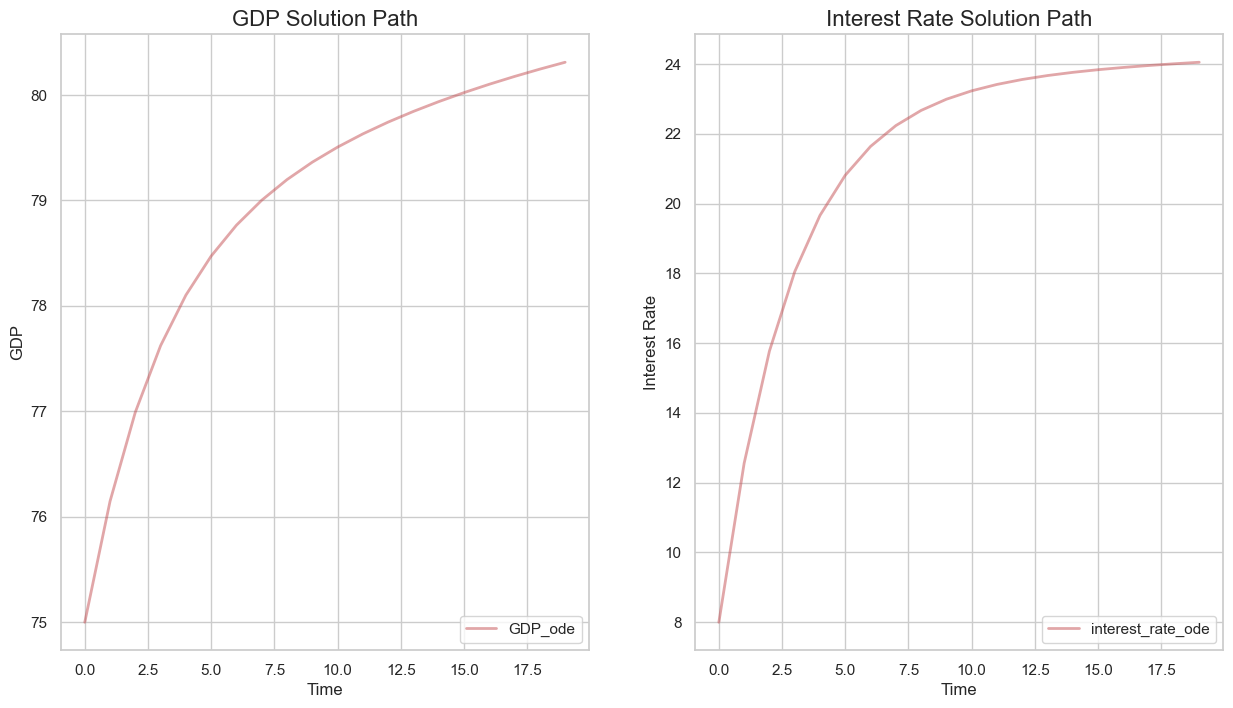

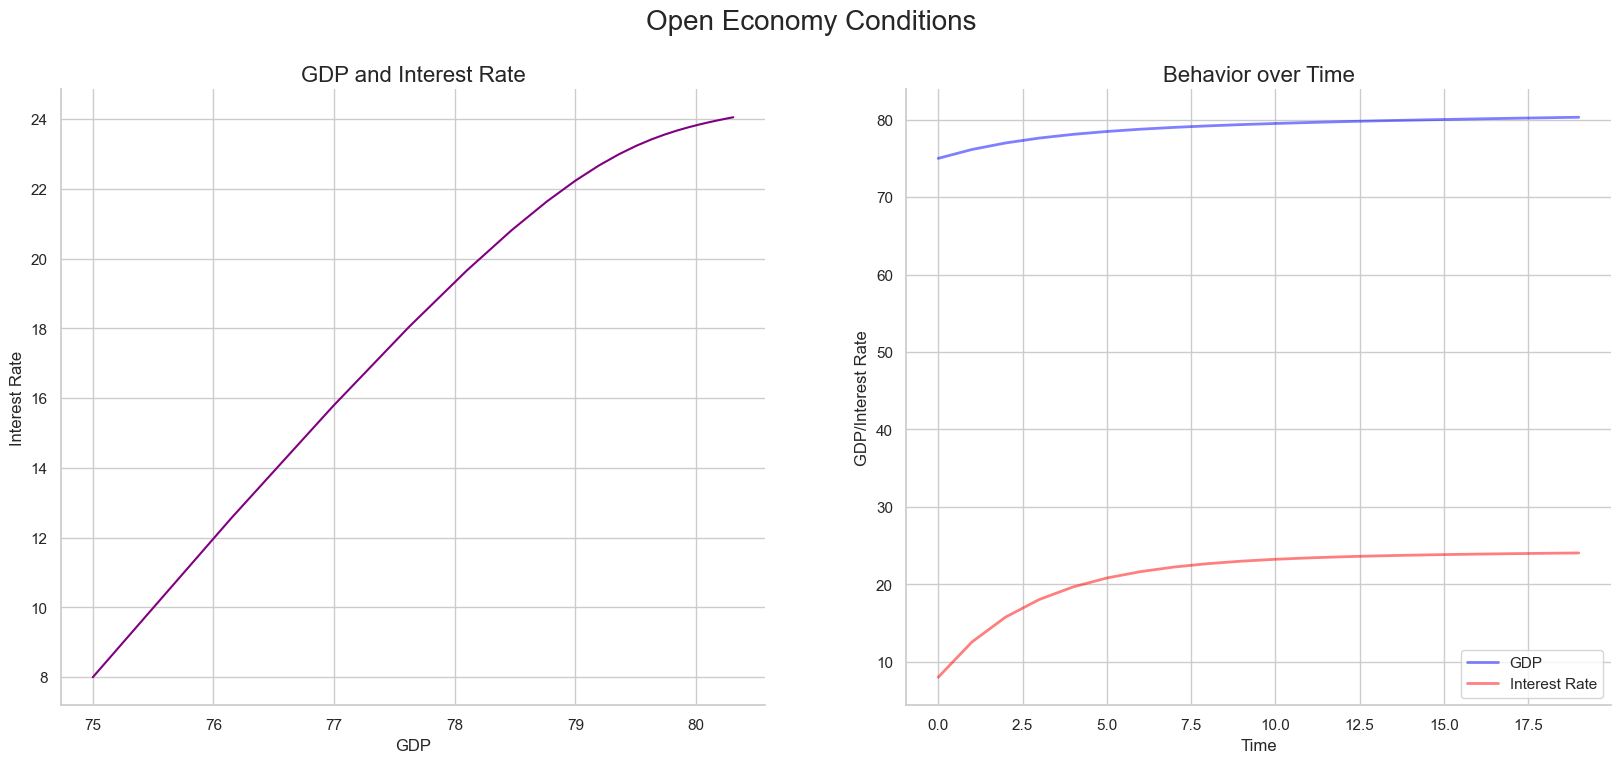

In [12]:
# Parameters for the model extension
a = 15  
I_0 = 10  
T_0 = 0  
M_0 = 0 
alpha_val = 0.05  
beta_val = 0.8  
lambda_val = 0.25  
b = 0.75  
h = 1.525 
k = 0.25 
mu_val = 0.5  
G = 25  
M = 8 
X = 5  # exports
IM = 2  # imports

time_points = np.arange(0, 20)

def IS_LM_model(u, t):    
    GDP, interest_rate = u[0], u[1]
    dYdt = ((alpha_val * (a - b * T_0 + I_0 + G + X - IM)) - 
            (alpha_val * ((1-b) * (1-lambda_val) * GDP)) - 
            (alpha_val * h * interest_rate)) 
    drdt = beta_val * (M_0 - M + k * GDP - (mu_val * interest_rate))
    return [dYdt, drdt]

# Initial conditions vector
Y_0 = 75
r_0 = 8

# Integrate the IS-LM differential equations over the time grid, t.
ret = odeint(IS_LM_model, [Y_0, r_0], time_points)

GDP_odeint, interest_rate_odeint = ret[:, 0], ret[:, 1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax = ax.flatten()
ax[0].plot(time_points, GDP_odeint, 'r', alpha=0.5, lw=2, label='GDP_ode')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('GDP')
ax[0].set_title('GDP Solution Path', fontsize=16)
ax[0].legend(loc=4)

ax[1].plot(time_points, interest_rate_odeint, 'r', alpha=0.5, lw=2, label='interest_rate_ode')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Interest Rate')
ax[1].set_title('Interest Rate Solution Path', fontsize=16)
ax[1].legend(loc=4)
plt.show()

def plot_graphs(GDP, interest_rate, t, case):
    """Visualize GDP and interest rate along with their behavior over time."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    plt.suptitle(case, fontsize=20)
    ax = ax.flatten()

    ax[0].plot(GDP, interest_rate, color='purple')
    ax[0].set_title('GDP and Interest Rate', fontsize=16)
    ax[0].set_xlabel('GDP')
    ax[0].set_ylabel('Interest Rate')
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    ax[1].plot(t, GDP, color='blue', alpha=0.5, lw=2, label='GDP')
    ax[1].plot(t, interest_rate, color='red', alpha=0.5, lw=2, label='Interest Rate')
    ax[1].set_title('Behavior over Time', fontsize=16)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('GDP/Interest Rate')
    ax[1].legend()
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    plt.show()

plot_graphs(GDP_odeint, interest_rate_odeint, time_points, 'Open Economy Conditions')


Now we want to examine the contractionary policy in an open economy.


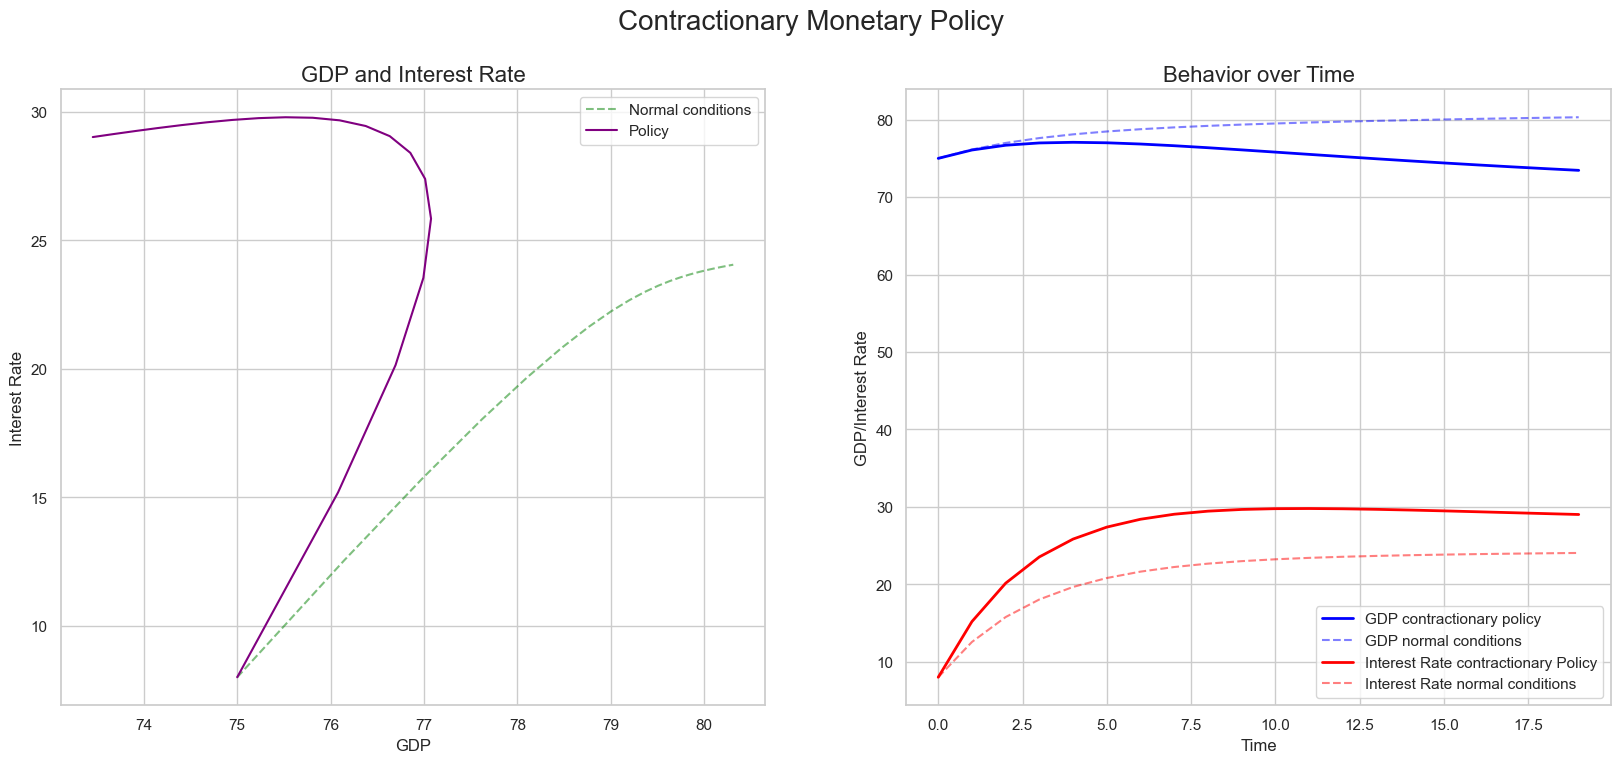

In [13]:
# Since all the parameters have already been defined, we only have to change the money supply and the variable taxes to see the effect on the model.
M = 4  # Changed money supply
lambda_val = 0.45  # increase in variable taxes

def contractionary_modification(GDP, interest_rate, t, case):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    plt.suptitle(case, fontsize=20)

    ax[0].plot(GDP_odeint, interest_rate_odeint, color='green', alpha=0.5, linestyle='--', label='Normal conditions')
    ax[0].plot(GDP, interest_rate, color='purple', label='Policy')
    ax[0].set_title('GDP and Interest Rate', fontsize=16)
    ax[0].set_xlabel('GDP')
    ax[0].set_ylabel('Interest Rate')
    ax[0].legend()

    ax[1].plot(t, GDP, color='blue', lw=2, label='GDP contractionary policy')
    ax[1].plot(t, GDP_odeint, color='blue', alpha=0.5, linestyle='--', label='GDP normal conditions')
    ax[1].plot(t, interest_rate, color='red', lw=2, label='Interest Rate contractionary Policy')
    ax[1].plot(t, interest_rate_odeint, color='red', alpha=0.5, linestyle='--', label='Interest Rate normal conditions')
    ax[1].set_title('Behavior over Time', fontsize=16)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('GDP/Interest Rate')
    ax[1].legend()

    plt.show()

args_tuple = (a, I_0, T_0, M_0, G, M, alpha_val, beta_val, lambda_val, b, h, k, mu_val)

# Integrate the IS-LM differential equations over the time grid
ret_contract = odeint(system, init_conds, time_points, args=args_tuple)

GDP_contract, interest_rate_contract = ret_contract.T

contractionary_modification(GDP_contract, interest_rate_contract, time_points, 'Contractionary Monetary Policy')

As evident from the figures above, a country's GDP is more significantly impacted in an open economy than in a closed one. This is because an open economy is influenced by external factors and international trade. Such an economy engages in both imports and exports, which in turn affects its GDP.